# 导入包

In [1]:
import gymnasium as gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils
import os

# 策略网络

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)  # 输出每个动作对应的概率

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)

# 价值网络

In [3]:
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1) # 输出状态对应的价值

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# A2C算法

优势评论员算法

## Todo list
- [ ] 实现路径衍生梯度策略

In [4]:
class ActorCritic:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, device):
        # 策略网络
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)  # 价值网络
        # 策略网络优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)  # 价值网络优化器
        self.gamma = gamma
        self.device = device

    def take_action(self, state):
        state = torch.tensor(state, dtype=torch.float).to(self.device)
        probs = self.actor(state.unsqueeze(0))
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()  # 取到的动作序号是tensor, 转成普通python数字

    def update(self, transition_dict):
        states = torch.tensor(np.array(transition_dict['states']), 
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(np.array(transition_dict['actions']), 
                               dtype=torch.int64).view(-1, 1).to(self.device)
        rewards = torch.tensor(np.array(transition_dict['rewards']), 
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(np.array(transition_dict['next_states']), 
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(np.array(transition_dict['dones']), 
                             dtype=torch.int).view(-1, 1).to(self.device)
        truncated = torch.tensor(np.array(transition_dict['truncated']), 
                                 dtype=torch.int).view(-1, 1).to(self.device)

        # 时序差分目标
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones | truncated)
        td_delta = td_target - self.critic(states)  # 时序差分误差
        log_probs = torch.log(self.actor(states).gather(1, actions))
        # 评论员/价值网络均方误差损失函数, td_target仅作为标量
        critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))  
        # 演员/策略网络误差, td_delta是从td_target来的, 因此也.detach(), 仅作为标量
        actor_loss = torch.mean(-log_probs * td_delta.detach())  
        self.critic_optimizer.zero_grad()
        self.actor_optimizer.zero_grad()
        critic_loss.backward()  # 计算价值网络的梯度
        actor_loss.backward()  # 计算策略网络的梯度
        self.critic_optimizer.step()  # 更新价值网络的参数
        self.actor_optimizer.step()  # 更新策略网络的参数

# 参数初始化

In [5]:
# A2C相关
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 1000
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('device: ', device)

# 环境相关
env_name = 'CartPole-v1'
env = gym.make(env_name)
torch.manual_seed(0)

# 神经网络相关
state_dim = env.observation_space.shape[0]
hidden_dim = 128
action_dim = env.action_space.n

agent = ActorCritic(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, device)

device:  cuda


# 读取检查点

In [6]:
def read_ckp(ckp_path):
    if os.path.exists(ckp_path):
        checkpoint = torch.load(ckp_path)
        s_epoch = checkpoint['epoch']
        s_episode = checkpoint['episode']
        agent.actor.load_state_dict(checkpoint['actor_best_weight'])
        agent.critic.load_state_dict(checkpoint['critic_best_weight'])
        reward_list = checkpoint['reward_list']
        return s_epoch, s_episode, reward_list
    else:
        s_epoch = 0
        s_episode = 0
        reward_list = []
        return s_epoch, s_episode, reward_list

In [7]:
CKP_PATH = 'checkpoints/ckpt_A2C.pt'
s_epoch, s_episode, reward_list = read_ckp(CKP_PATH)

# 训练函数

In [17]:
rl_utils.train_on_policy_agent(env, agent, s_epoch=s_epoch,  total_epoch=10, 
                               s_episode=s_episode, total_episode=100,
                               reward_list=reward_list, ckp_path=CKP_PATH)

# 作图

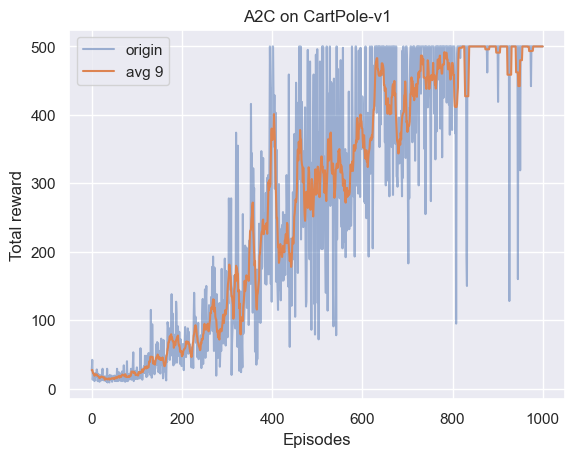

In [10]:
rl_utils.picture_reward(reward_list, 'A2C', env_name, 9)